## Семинар 5: "Улучшение сходимости нейросетей"

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Инициализация весов
* Dropout
* Batch Normalization


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [ ]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [ ]:
images_train, labels_train = next(iter(train_loader))

In [ ]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

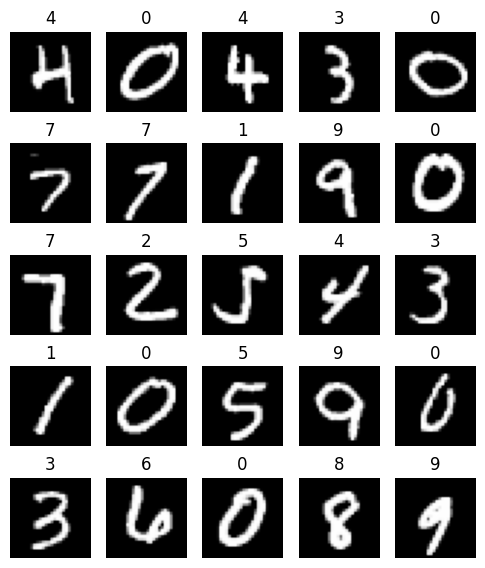

In [ ]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Создадим два линейных слоя и инициализируем их случайным образом. Для этого используем uniform распределение с нулевым средним и большим отклонением.

In [ ]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [ ]:
layer_1 = nn.Linear(...)
layer_2 = nn.Linear(...)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [ ]:
network = nn.Sequential(
    ...
)

Посчитаем дисперсию активаций и диспресию градиентов:

In [ ]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

Теперь попробуем использовать инициализацию He:<br>
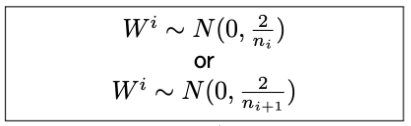

In [ ]:
layer_1 = nn.Linear(...)
layer_2 = nn.Linear(...)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1, ...)
init_layer(layer_2, ...)

In [ ]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

## Часть 2: Dropout

Реализуем Dropout:

* Train: с вероятностью p занулим выход нейрона (например, p = 0.5)
* Test: домножаем веса на вероятность сохранения

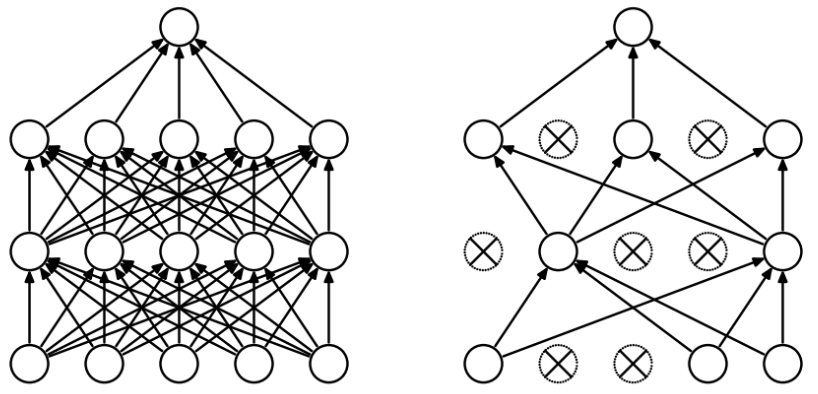


In [ ]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = # YOUR CODE HERE
        if self.training:
            mask = # YOUR CODE HERE
        else:
            mask = # YOUR CODE HERE

        return # YOUR CODE HERE

Основа для сети, которую будем обучать:

In [ ]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [ ]:
layers = [
    # YOUR CODE HERE
]

In [ ]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [ ]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))
